# DeepSeedlings: Pre-trained CNN with simple classifier

In [28]:
%matplotlib inline
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16
import numpy as np
import os
import pandas as pd
import seaborn as sns
from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from tqdm import tqdm

In [3]:
from keras.applications import vgg16, vgg19, inception_v3, resnet50, xception
from keras.models import Model

In [4]:
CATEGORIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
              'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
NUM_CATEGORIES = len(CATEGORIES)

In [5]:
SAMPLE_PER_CATEGORY = 200
SEED = 1987
data_dir = './data/'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

In [6]:
for category in CATEGORIES:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(train_dir, category)))))

Black-grass 263 images
Charlock 390 images
Cleavers 287 images
Common Chickweed 611 images
Common wheat 221 images
Fat Hen 475 images
Loose Silky-bent 654 images
Maize 221 images
Scentless Mayweed 516 images
Shepherds Purse 231 images
Small-flowered Cranesbill 496 images
Sugar beet 385 images


In [9]:
train = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['train/{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])
train.head(2)

,file,category_id,category
0,train/Black-grass/5a1295fb4.png,0,Black-grass
1,train/Black-grass/d8afd58f3.png,0,Black-grass


In [8]:
train.shape

(4750, 3)

In [11]:
train = pd.concat([train[train['category'] == c][:SAMPLE_PER_CATEGORY] for c in CATEGORIES])
train = train.sample(frac=1)
train.index = np.arange(len(train))
train.head(2)

,file,category_id,category
0,train/Sugar beet/5374f4b77.png,11,Sugar beet
1,train/Shepherds Purse/f2fb09190.png,9,Shepherds Purse


In [12]:
train.shape

(2400, 3)

In [14]:
test = []
for file in os.listdir(test_dir):
    test.append(['test/{}'.format(file), file])
test = pd.DataFrame(test, columns=['filepath', 'file'])
test.head(2)

,filepath,file
0,test/1b490196c.png,1b490196c.png
1,test/85431c075.png,85431c075.png


In [15]:
test.shape

(794, 2)

In [16]:
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_dir, filepath), target_size=size)
    img = image.img_to_array(img)
    return img

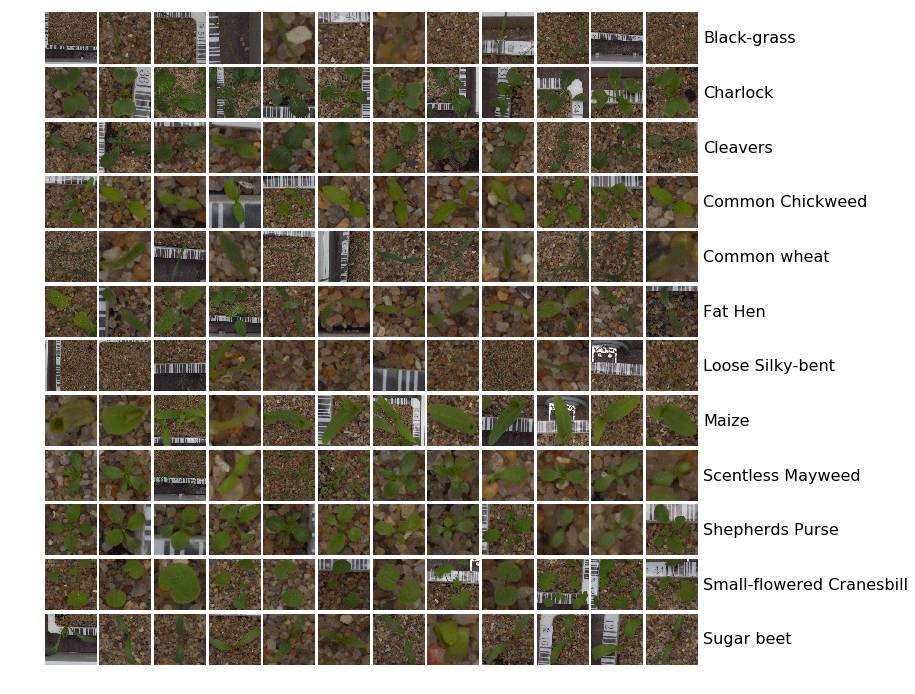

In [19]:
fig = plt.figure(1, figsize=(NUM_CATEGORIES, NUM_CATEGORIES))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05)
i = 0
for category_id, category in enumerate(CATEGORIES):
    for filepath in train[train['category'] == category]['file'].values[:NUM_CATEGORIES]:
        ax = grid[i]
        img = read_img(filepath, (224, 224))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
            ax.text(250, 112, filepath.split('/')[1], verticalalignment='center')
        i += 1
plt.show();

In [20]:
np.random.seed(seed=SEED)
rnd = np.random.random(len(train))
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
ytr = train.loc[train_idx, 'category_id'].values
yv = train.loc[valid_idx, 'category_id'].values
len(ytr), len(yv)

(1899, 501)

In [21]:
INPUT_SIZE = 299
POOLING = 'avg'
x_train = np.zeros((len(train), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, file in tqdm(enumerate(train['file'])):
    img = read_img(file, (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

2400it [00:36, 65.72it/s]


Train Images shape: (2400, 299, 299, 3) size: 643,687,200


In [24]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, pooling=POOLING)
train_x_bf = xception_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_x_bf = xception_bottleneck.predict(Xv, batch_size=32, verbose=1)
print('Xception train bottleneck features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size))
print('Xception valid bottleneck features shape: {} size: {:,}'.format(valid_x_bf.shape, valid_x_bf.size))

((1899, 299, 299, 3), (501, 299, 299, 3), (1899,), (501,))
501/501 [==============================] - 291s 580ms/step
Xception train bottleneck features shape: (1899, 2048) size: 3,889,152
Xception valid bottleneck features shape: (501, 2048) size: 1,026,048


In [25]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_x_bf, ytr)
valid_probs = logreg.predict_proba(valid_x_bf)
valid_preds = logreg.predict(valid_x_bf)

In [29]:
print('Validation Xception Accuracy {}'.format(metrics.accuracy_score(yv, valid_preds)))

Validation Xception Accuracy 0.8343313373253493


In [31]:
print(metrics.classification_report(yv, valid_preds))

             precision    recall  f1-score   support

          0       0.67      0.66      0.67        44
          1       0.93      0.95      0.94        43
          2       0.97      0.93      0.95        41
          3       0.72      0.70      0.71        40
          4       0.98      0.85      0.91        48
          5       0.81      0.87      0.84        39
          6       0.65      0.81      0.72        42
          7       0.98      0.93      0.96        46
          8       0.82      0.78      0.80        46
          9       0.65      0.69      0.67        35
         10       0.90      0.93      0.92        41
         11       0.97      0.89      0.93        36

avg / total       0.84      0.83      0.84       501



In [34]:
cnf_matrix = confusion_matrix(yv, valid_preds)

In [32]:
abbreviation = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']
pd.DataFrame({'class': CATEGORIES, 'abbreviation': abbreviation})

,abbreviation,class
0,BG,Black-grass
1,Ch,Charlock
2,Cl,Cleavers
3,CC,Common Chickweed
4,CW,Common wheat
5,FH,Fat Hen
6,LSB,Loose Silky-bent
7,M,Maize
8,SM,Scentless Mayweed
9,SP,Shepherds Purse


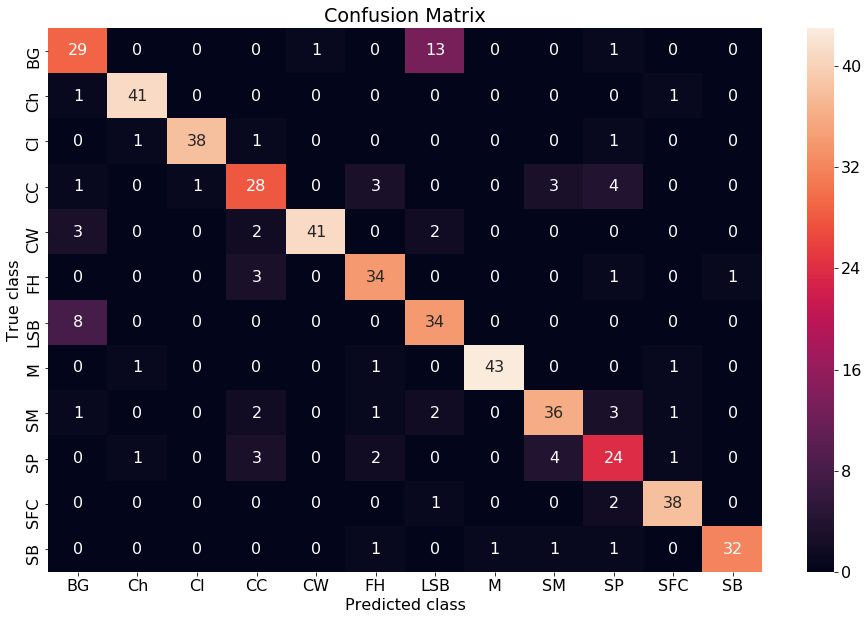

In [38]:
fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax,  annot=True)
ax.set_xticklabels(abbreviation)
ax.set_yticklabels(abbreviation)
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show();

In [36]:
x_test = np.zeros((len(test), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, filepath in tqdm(enumerate(test['filepath'])):
    img = read_img(filepath, (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_test[i] = x
print('test Images shape: {} size: {:,}'.format(x_test.shape, x_test.size))

794it [00:05, 144.58it/s]

test Images shape: (794, 299, 299, 3) size: 212,953,182


In [37]:
test_x_bf = xception_bottleneck.predict(x_test, batch_size=32, verbose=1)
print('Xception test bottleneck features shape: {} size: {:,}'.format(test_x_bf.shape, test_x_bf.size))
test_preds = logreg.predict(test_x_bf)

794/794 [==============================] - 546s 688ms/step
Xception test bottleneck features shape: (794, 2048) size: 1,626,112


In [41]:
CATEGORIES[test_preds[0]]

'Shepherds Purse'

In [58]:
def model(filepath):
    img = read_img(filepath, (299,299))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis = 0))
    x_bottleneck = xception_bottleneck.predict(x, verbose = 1)
    pred = logreg.predict(x_bottleneck)
    return CATEGORIES[pred[0]]

In [59]:
model('/Users/emilygeller/ds/metis/metisgh/Geller_Metis/Project 5/data/test/0a64e3e6c.png')

1/1 [==============================] - 1s 507ms/step


'Black-grass'

In [50]:
from keras.models import load_model

#xception_bottleneck.save('xception_bottleneck.h5')  # creates a HDF5 file 'my_model.h5'


# returns a compiled model
# identical to the previous one
# model = load_model('my_model.h5')

In [51]:
import pickle
#pickle.dump(logreg, open("logreg.p", "wb"))

In [52]:
#model = load_model('xception_bottleneck.h5')

/Users/emilygeller/anaconda3/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [53]:
model.predict(x_test, batch_size = 32)

KeyboardInterrupt: 

In [66]:
import datetime as dt
dt.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

'2018-03-24-18-28-08'

In [63]:
import time
time.gmtime()

time.struct_time(tm_year=2018, tm_mon=3, tm_mday=25, tm_hour=1, tm_min=26, tm_sec=11, tm_wday=6, tm_yday=84, tm_isdst=0)